In [0]:
!mkdir /data
!mkdir /data/data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data/data

## Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [0]:
#import libraries

import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import glob 
from PIL import Image
import matplotlib.image as mpimg
import os 
import torch
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 0
seed_everything(seed)

In [0]:
#load training csv 

train_csv = pd.read_csv("/data/data/training_frames_keypoints.csv")
print (train_csv.head())
print (len(train_csv))

                   Unnamed: 0     0     1     2  ...   132    133   134    135
0           Luis_Fonsi_21.jpg  45.0  98.0  47.0  ...  81.0  122.0  77.0  122.0
1       Lincoln_Chafee_52.jpg  41.0  83.0  43.0  ...  83.0  122.0  79.0  122.0
2       Valerie_Harper_30.jpg  56.0  69.0  56.0  ...  75.0  105.0  73.0  105.0
3         Angelo_Reyes_22.jpg  61.0  80.0  58.0  ...  91.0  139.0  85.0  136.0
4  Kristen_Breitweiser_11.jpg  58.0  94.0  58.0  ...  88.0  122.0  84.0  122.0

[5 rows x 137 columns]
3462


In [0]:
# visualize images 

def show_keypoint(image,key_pts):
  plt.imshow(image)
  plt.scatter(key_pts[:,0],key_pts[:,1],s=20,marker='.',c='m')  

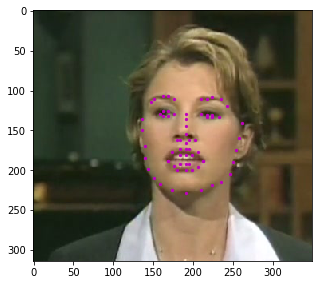

In [0]:
n = 1002
image_name = train_csv.iloc[n,0]
key_pts = train_csv.iloc[n,1:].values.astype("float").reshape(-1,2)

image = Image.open("/data/data/training/" + image_name)

plt.figure(figsize=(5,5))
show_keypoint(image, key_pts)
image = np.array(image)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

(1123, 3064, 4)


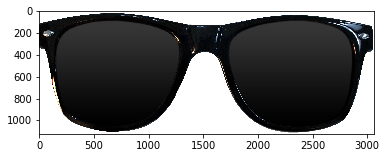

In [0]:
sunglasses = cv2.imread("/images/sunglasses.png",cv2.IMREAD_UNCHANGED)
plt.imshow(sunglasses)
print (sunglasses.shape)

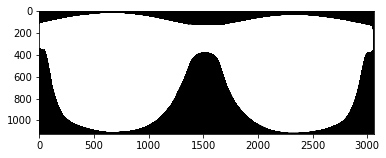

In [0]:
alpha_channel = sunglasses[:,:,3]
plt.imshow(alpha_channel,cmap='gray')

#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,


It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

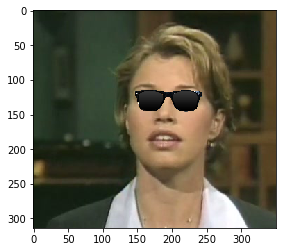

In [0]:
image_copy = image.copy()

#17 keypoint -- left eyebrow
x = int(key_pts[17,0])
y = int(key_pts[17,1])

#height of noise 
h = int(abs(key_pts[27,1] - key_pts[34,1]))

#width of eyebrows 
w = int(abs(key_pts[17,0] - key_pts[26,0]))

new_sunglasses = cv2.resize(sunglasses,(w,h),interpolation = cv2.INTER_CUBIC)
roi_face = image_copy[y:y+h, x:x+w]
ind = np.argwhere(new_sunglasses[:,:,3] > 0)


for i in range(3):
  roi_face[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]

image_copy[y:y+h,x:x+w] = roi_face
plt.imshow(image_copy)


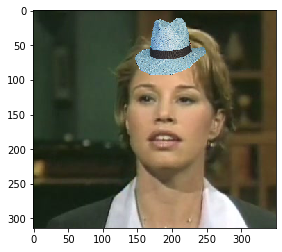

In [0]:
straw = cv2.imread("/images/straw_hat.png",cv2.IMREAD_UNCHANGED)

image_straw = image.copy()

x = int(key_pts[1,0])
y = 0
h = int(abs(key_pts[19,1]))
w = int(abs(key_pts[16,0] - key_pts[1,0]))

straw_new = cv2.resize(straw,(w,h),interpolation = cv2.INTER_CUBIC)
roi_face = image_straw[y:y+h, x:x+w]
ind = np.argwhere(straw_new[:,:,3] > 0)

for i in range(3):
  roi_face[ind[:,0],ind[:,1],i] = straw_new[ind[:,0],ind[:,1],i]

image_straw[y:y+h,x:x+w] = roi_face
plt.imshow(image_straw)


In [0]:
#Function to vizualize points with their numberings 

def viz_points(image,key_pts):
  plt.imshow(image)
  # plt.scatter(key_pts[:,0],key_pts[:,1],s=20,marker='.',c='m')  
  n = list(range(len(key_pts)))
  fig, ax = plt.subplots()
  ax.scatter(key_pts[:,0],key_pts[:,1])
  texts = []
  for i, txt in enumerate(n):
    texts.append(ax.text(key_pts[i,0], key_pts[i,1], txt))
  plt.show()

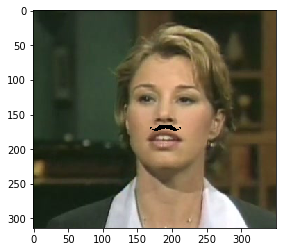

In [0]:
mous = cv2.imread("/images/moustache.png",cv2.IMREAD_UNCHANGED)
# viz_points(image,key_pts)


image_mous = image.copy()

x = int(key_pts[48,0])
y = int(key_pts[31,1])
h = int(abs(key_pts[62, 1] - key_pts[33, 1]))
w = int(abs(key_pts[54,0] - key_pts[48,0]))


mous_new = cv2.resize(mous,(w,h),interpolation = cv2.INTER_CUBIC)
roi_face = image_mous[y:y+h, x:x+w]
ind = np.argwhere(mous_new[:,:,3] > 0)

for i in range(3):
  roi_face[ind[:,0],ind[:,1],i] = mous_new[ind[:,0],ind[:,1],i]

image_mous[y:y+h,x:x+w] = roi_face
plt.imshow(image_mous)


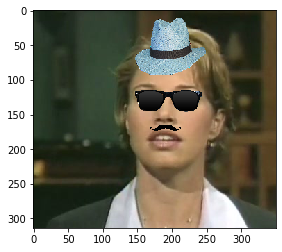

In [0]:
image_final = image.copy()

x = int(key_pts[48,0])
y = int(key_pts[31,1])
h = int(abs(key_pts[62, 1] - key_pts[33, 1]))
w = int(abs(key_pts[54,0] - key_pts[48,0]))

mous_new = cv2.resize(mous,(w,h),interpolation = cv2.INTER_CUBIC)
roi_face = image_final[y:y+h, x:x+w]
ind = np.argwhere(mous_new[:,:,3] > 0)

for i in range(3):
  roi_face[ind[:,0],ind[:,1],i] = mous_new[ind[:,0],ind[:,1],i]

image_final[y:y+h,x:x+w] = roi_face

x = int(key_pts[1,0])
y = 0
h = int(abs(key_pts[19,1]))
w = int(abs(key_pts[16,0] - key_pts[1,0]))

straw_new = cv2.resize(straw,(w,h),interpolation = cv2.INTER_CUBIC)
roi_face = image_final[y:y+h, x:x+w]
ind = np.argwhere(straw_new[:,:,3] > 0)

for i in range(3):
  roi_face[ind[:,0],ind[:,1],i] = straw_new[ind[:,0],ind[:,1],i]

image_final[y:y+h,x:x+w] = roi_face


x = int(key_pts[17,0])
y = int(key_pts[17,1])
h = int(abs(key_pts[27,1] - key_pts[34,1]))
w = int(abs(key_pts[17,0] - key_pts[26,0]))

new_sunglasses = cv2.resize(sunglasses,(w,h),interpolation = cv2.INTER_CUBIC)
roi_face = image_final[y:y+h, x:x+w]
ind = np.argwhere(new_sunglasses[:,:,3] > 0)


for i in range(3):
  roi_face[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]

image_final[y:y+h,x:x+w] = roi_face
plt.imshow(image_final)